# Quick Overview

This chapter gives a quick overview into how to use the package. Detailed explanations can be found in the [userguide](../userguide/index.rst).

Start by importing the package:

In [1]:
import h5rdmtoolbox as h5tbx

## Difference to `h5py` package

The `h5RDMtoolbox` is built upon the `h5py` package. The base functionality is kept, but convenient features and interfaces are added.

### Filename
A filename must not be provided when creating a new file. If none is provided, a temporary file is created. Also, `hdf_filename` is provided as an additional property allowing to work with the filename even after the file has been closed *and* to work with `pathlib.Path` objects instead of strings:

In [2]:
with h5tbx.use(None):
    with h5tbx.File() as h5:
        pass
h5.hdf_filename.name  # equal to h5.filename but a pathlib.Path and exists also after the file is closed

'tmp0.hdf'

## Additional arguments

Here and there, the toolbox allows one-liners, e.g. by creating attributes during dataset creation. In the following example the dataset is also marked as a dimension scale:

In [3]:
import rdflib

In [4]:
with h5tbx.File() as h5:
    ds_time = h5.create_dataset(name='time',
                                data=[0, 1, 2, 3],
                                attrs=dict(units='s',
                                           long_name='measurement time'),
                                make_scale=True)

### Datasets/xarray interface

Data access will not return `np.ndarray` but a `xr.DataArray` object. It is capable of storing attributes and coordinates (similar concept as HDF dimension scales). Find out about all possibilities this give on [xarray's documentation](https://xarray.pydata.org/).

Let's create some sample data and see how this new return object can help:

In [5]:
import numpy as np

time = np.linspace(0, np.pi/4, 21) # units [s]
signal = np.sin(2*np.pi*3*time) # units [V], physical: [m/s]

with h5tbx.File() as h5:
    vel_hdf_filename = h5.hdf_filename # store for later use
    
    ds_time = h5.create_dataset(name='time',
                                data=time,
                                attrs=dict(units='s',
                                           long_name='measurement time'),
                                make_scale=True)
    
    ds_signal = h5.create_dataset(name='vel',
                                  data=signal,
                                  attrs=dict(units='m/s',
                                             long_name='air velocity in pipe'),
                                  attach_scale=ds_time)

Inspired by `xarray` the methods `sel` and `isel` are implemented:

In [6]:
with h5tbx.File(vel_hdf_filename) as h5:
    vel2 = h5['vel'].sel(time=2, method='nearest')
vel2

<xarray.DataArray 'vel' ()> Size: 8B
0.7855
Coordinates:
    time     float64 8B 0.7854
Attributes:
    long_name:  air velocity in pipe
    units:      m/s

Another advantage is using the plotting util form `xarray`:

<xarray.DataArray 'vel' (time: 21)> Size: 168B
0.0 0.6745 0.9959 0.7962 0.1797 -0.5308 ... -0.6615 0.01737 0.6872 0.9973 0.7855
Coordinates:
  * time     (time) float64 168B 0.0 0.03927 0.07854 ... 0.7069 0.7461 0.7854
Attributes:
    long_name:  air velocity in pipe
    units:      m/s

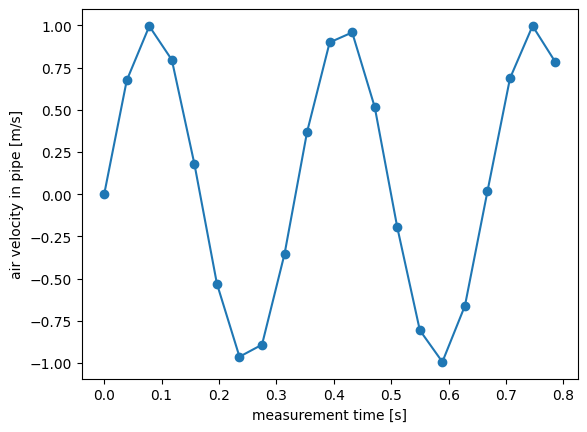

In [7]:
with h5tbx.File(vel_hdf_filename) as h5:
    vel_data = h5['vel'][:]
    vel_data.plot(marker='o')
    
vel_data  # this returns the interactive view of the array and its meta data

### Natural Naming
Until here, we used the conventional way of addressing variables and groups in a dictionary-like style. `h5RDMtoolbox` allows using "natural naming" which means that we can address those objects as if they were attributes. Make sure `h5tbx.config.natural_naming` is set to `True` (the default)

Let's first disable `natural_naming`:

In [8]:
with h5tbx.set_config(natural_naming=False):
    with h5tbx.File(vel_hdf_filename, 'r') as h5:
        try:
            ds = h5.vel[:]
        except Exception as e:
            print(e)

'File' object has no attribute 'vel'


Enable it:

In [9]:
with h5tbx.set_config(natural_naming=True):
    with h5tbx.File(vel_hdf_filename, 'r') as h5:
        ds = h5.vel[:]

## Inspect file content
Often it is necessary to inspect the content of a file (structure, metadata, not the raw data). Calling `dump()` on a group represents the content (dataset, groups and attributes) as a pretty and interactive (!) HTML representation. This is adopted from the `xarray` package. All credits for this idea go there. The representation here avoids showing data, though. Outside an IPython environment, call `sdump()` to get a string representation of the file.

In [10]:
with h5tbx.File(vel_hdf_filename) as h5:
    h5.dump()

In [11]:
with h5tbx.File(vel_hdf_filename) as h5:
    h5.sdump()

time: (21,), dtype: float64
    a: long_name: measurement time
    a: units: s
vel: (21,), dtype: float64
    a: long_name: air velocity in pipe
    a: units: m/s


## Conventions
The file content is controlled by means of a `convention`. This means that specific attributes are required for HDF groups or datasets.

They can be understood as rules, which are validated during usage. To make those rules to become effective, the convention must be imported and enabled. Conventions can be created by the user, too. More on this [here](../userguide/convention/index.rst).

For now, we select the existing one, which is published on [Zenodo](https://zenodo.org/record/10428795)

In [12]:
cv = h5tbx.convention.from_zenodo('10428822')
cv

A target folder was specified. Downloading file to this folder: .


Convention("h5rdmtoolbox-tutorial-convention")

From the above representation string of the convention object we can read which attributes are *optional* or **required** for file creation (`__init__`), dataset creation (`create_dataset`) or group creation (`create_group`).

Without enabling the convention, the working with HDF5 files through the `h5rdmtoolbox` is almost (we got a few additional features which make life a bit easier) as by using `h5py`:

In [13]:
with h5tbx.File() as h5:
    h5.dump()

**Now, we enable the convention ...**

In [14]:
h5tbx.use(cv)

using("h5rdmtoolbox-tutorial-convention")

... and get an error, because we are not providing a "data_type":

In [15]:
try:
    with h5tbx.File() as h5:
        pass
except Exception as e:
    print(e)

Convention "h5rdmtoolbox-tutorial-convention" expects standard attribute "data_type" to be provided as an argument during file creation.


In [16]:
import numpy as np

time = np.linspace(0, np.pi/4, 21) # units [s]
signal = np.sin(2*np.pi*3*time) # units [V], physical: [m/s]

with h5tbx.File(contact=h5tbx.__author_orcid__, data_type='experimental') as h5:
    vel_hdf_filename = h5.hdf_filename # store for later use
    
    ds_time = h5.create_dataset(name='time',
                                data=time, 
                                units='s',
                                long_name='measurement time',
                                make_scale=True)
    
    ds_signal = h5.create_dataset(name='vel',
                                  data=signal,
                                  units='m/s',
                                  long_name='air velocity in pipe',
                                  attach_scale=ds_time)

## RDF

The files can be described by RDF triples:

In [17]:
h5tbx.use(None)
with h5tbx.File() as h5:
    # file attributes, that should semantically be associated to the file rather than the root group:
    h5.attrs["title"] = "Test file"
    h5.frdf["title"].predicate = "https://schema.org/title"
    h5.frdf["title"].object = "https://example.org/test-title"

    h5.attrs["created"] = "2025-10-3"
    h5.frdf["created"].predicate = "http://purl.org/dc/terms/created"
    
    grp = h5.create_group('contact', attrs=dict(orcid='https://orcid.org/0000-0001-8729-0482'))   
    grp.rdf.predicate = 'https://schema.org/author'
    grp.rdf.type = 'http://xmlns.com/foaf/0.1/Person'  # what the content of group is, namely a foaf:Person
    grp.rdf.subject = 'https://orcid.org/0000-0001-8729-0482'  # corresponds to @ID in JSON-LD
    
    grp.rdf['orcid'].predicate =  'http://w3id.org/nfdi4ing/metadata4ing#orcidId'
    
    grp.attrs['first_name', 'http://xmlns.com/foaf/0.1/firstName'] = 'Matthias'

    h5.dump()

One of the benefits is that the user can understand the meaning of the data. A machine-interpretable and standardised common exchange file format used by Semantic Web technology is JSON-LD. The toolbox also allows exporting to this format:

In [18]:
print(h5tbx.serialize(h5.hdf_filename, format="ttl"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix hdf: <http://purl.allotrope.org/ontologies/hdf5/1.8#> .
@prefix m4i: <http://w3id.org/nfdi4ing/metadata4ing#> .
@prefix schema: <https://schema.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://orcid.org/0000-0001-8729-0482> a foaf:Person ;
    m4i:orcidId "https://orcid.org/0000-0001-8729-0482"^^xsd:string ;
    foaf:firstName "Matthias"^^xsd:string .

[] a hdf:File ;
    hdf:rootGroup [ a hdf:Group ;
            hdf:attribute [ a hdf:StringAttribute ;
                    hdf:data "2025-10-3"^^xsd:string ;
                    hdf:name "created" ],
                [ a hdf:StringAttribute ;
                    hdf:data "Test file"^^xsd:string ;
                    hdf:name "title" ] ;
            hdf:member [ a hdf:Group ;
                    hdf:attribute [ a hdf:StringAttribute ;
                            hdf:data "Matthias"^^xsd:string ;
                           

## Databases

The `h5rdmtoolbox` has currently implemented two solutions to use databases with HDF5 file. One solution is mapping metadata into a [mongoDB](https://www.mongodb.com/) database. The other uses the HDF5 file itself as a database and allows querying without any further step.

In this quick tutorial, we use the second solution. More on the topic can be found in the [documentation](https://h5rdmtoolbox.readthedocs.io/en/latest/database/index.html)

Let's find the dataset with name "/vel" (yes, trivial in this case, but just to get an idea). We use `find_one`, because we want to find only one (the first) occurrence:

In [19]:
from h5rdmtoolbox.database import FileDB

In [20]:
res = FileDB(vel_hdf_filename).find_one({'$name': '/vel'})
print(res.name)

/vel


The same can be done from an opened file, too:

In [21]:
with h5tbx.File(vel_hdf_filename) as h5:
    res = h5.find_one({'$name': '/vel'})
res.name

'/vel'

Let's find all (`find`) datasets with the attribute "units" and any value:

In [22]:
res = FileDB(vel_hdf_filename).find({'units': {'$regex': '.*'}})
for r in res:
    print(r)

<LDataset "/time" in "C:\Users\matth\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\2.4.0rc1\tmp\tmp_0\tmp5.hdf" attrs=(long_name=measurement time, units=s)>
<LDataset "/vel" in "C:\Users\matth\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\2.4.0rc1\tmp\tmp_0\tmp5.hdf" attrs=(long_name=air velocity in pipe, units=m/s)>


## Layouts

Layouts define how a file is expected to be organized, which groups and datasets must exist, which attributes are expected and much more. Layout define expectations and thus help file exchange where multiple users are involved. In the jargon of the toolbox, we call these "specifications".

**Design concept**<br>
The module *layouts* makes use of the database solution for HDF5 files. The idea is, that we should be able to formulate our expectations/specifications in the form of a query. For more detailed information, see [here](https://h5rdmtoolbox.readthedocs.io/en/latest/layouts.html). So we write down our queries, which we expect to find HDF5 objects in a file, when we validate one in the future.

Let's design a simple one, which requires all datasets to have the attribute "units":

In [23]:
from h5rdmtoolbox.layout import Layout

In [24]:
lay = Layout()

spec_all_dataset = lay.add(
    FileDB.find,  # query function
    flt={},
    objfilter='dataset',
    n=None
)

# The following specification is added to the previous.
# This will apply the query only on results found by the previous query
spec_compression = spec_all_dataset.add(
    FileDB.find,
    flt={'units': {'$exists': True}}, # attribute "units" exists
    n=1
)

# we added one specification to the layout. let's check:
lay.specifications  # note, that the second specification is not shown, because it is part of the first one

[LayoutSpecification(kwargs={'flt': {}, 'objfilter': 'dataset'})]

In [25]:
res = lay.validate(vel_hdf_filename)
res.is_valid()

True

In [26]:
res.print_summary(exclude_keys=('kwargs', 'target_name', 'target_type'))


Summary of layout validation
+--------------------------------------+----------+--------+----------------------+---------------+-----------------------------------------+
| id                                   | called   |   flag | flag description     | description   | func                                    |
|--------------------------------------+----------+--------+----------------------+---------------+-----------------------------------------|
| 3ee6e45a-c364-450e-936e-a05d43aece34 | True     |     17 | SUCCESSFUL, OPTIONAL |               | h5rdmtoolbox.database.hdfdb.filedb.find |
| 85904609-5b09-45ba-86fd-d84d7820ff2b | True     |      1 | SUCCESSFUL           |               | h5rdmtoolbox.database.hdfdb.filedb.find |
| 85904609-5b09-45ba-86fd-d84d7820ff2b | True     |      1 | SUCCESSFUL           |               | h5rdmtoolbox.database.hdfdb.filedb.find |
+--------------------------------------+----------+--------+----------------------+---------------+-------------------

The above layout successfully validate the file.

Now, let's add the specification:
- The file must have one dataset named "pressure".
- The exact location within the file does not play a role.
- This specific dataset must have the unit "Pa":
- The shape of the dataset must be equal to (21, )

In [27]:
lay.add(
    FileDB.find_one,  # query function
    flt={'$name': {'$regex': 'pressure'}, 
         '$shape': (21, ),
         'units': 'Pa'},
    objfilter='dataset',
    n=1
)
lay.specifications

[LayoutSpecification(kwargs={'flt': {}, 'objfilter': 'dataset'}),
 LayoutSpecification(kwargs={'flt': {'$name': {'$regex': 'pressure'}, '$shape': (21,), 'units': 'Pa'}, 'objfilter': 'dataset'})]

The validation now fails:

In [28]:
res = lay.validate(vel_hdf_filename)
res.is_valid()

2025-10-12_13:31:49,722 ERROR    [core.py:330] Applying spec. "LayoutSpecification(kwargs={'flt': {'$name': {'$regex': 'pressure'}, '$shape': (21,), 'units': 'Pa'}, 'objfilter': 'dataset'})" failed due to not matching the number of results: 1 != 0


False

Let's add such a dataset:

In [29]:
with h5tbx.File(vel_hdf_filename, 'r+') as h5:
    h5.create_dataset('subgrp/pressure', shape=(21,), attrs={'units': 'Pa'})

And perform the validation again:

In [30]:
res = lay.validate(vel_hdf_filename)
res.is_valid()

True

Feel free to play with the layout specifications and the HDF5 file content. For sure, knowledge about performing queries with the used database is needed.

## Repositories

Finally, we can publish our data. The toolbox has implemented an interface to [Zenodo](https://zenodo.org/). Using it with the sandbox (testing) environment requires an API TOKEN. For this, please provide the environment variable "ZENODO_SANDBOX_API_TOKEN":

In [31]:
# %set_env ZENODO_SANDBOX_API_TOKEN=<your token>

In [32]:
from h5rdmtoolbox.repository import zenodo
from datetime import datetime

Create a new deposit (repo in the testing environment):

In [33]:
deposit = zenodo.ZenodoSandboxDeposit(None)

Prepare metadata according to the Zenodo API: 

In [34]:
meta = zenodo.metadata.Metadata(
    version="1.0.0",
    title='H5TBX Quick Overview Test',
    description=f'The file created in the quick overview script using the h5rdmtoolbox version {h5tbx.__version__}.',
    creators=[zenodo.metadata.Creator(name="Probst, Matthias",
                                      affiliation="Karlsruhe Institute of Technology, Institute for Thermal Turbomachinery",
                                      orcid="0000-0001-8729-0482")],
    upload_type='dataset',
    access_right='open',
    keywords=['h5rdmtoolbox', 'tutorial', 'repository-test'],
    publication_date=datetime.now(),
)

push metadata to the repository:

In [35]:
deposit.metadata = meta

**Upload the HDF5 file:**<br>
As HDF5 files cannot be previewed in the repository web interface and HDF5 files may become very large, it is handy to upload a metadata file as an additional resource. This allows to preview the metadata content before downloading the larger HDF5 file.

This functionality is given by the upload method `.upload_file`, which takes the optional parameter `metamapper`. Please provide a function which creates a file with metadata. The toolbox comes with a solution, that maps the HDF5 metadata content into a JSON-LD file:

In [36]:
from h5rdmtoolbox import jsonld

In [37]:
deposit.upload_file(filename=vel_hdf_filename, metamapper=jsonld.hdf2jsonld, skipND=1) # skipND is needed by hdf2jsonld